In [1]:
import csv
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import Preprocessing as pp
from scipy.io import loadmat
from sklearn import metrics

In [2]:
temp_data_folder = '../Data/Temp_Data/'

## Import Data and small visualisation

In [3]:
df_validation = pp.openCSVFile('experiment_1.csv', temp_data_folder)

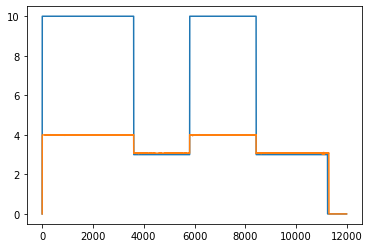

In [4]:
plt.plot(df_validation['time'], df_validation['voltage'])
plt.plot(df_validation['time'], df_validation['spinning']/1000)
plt.show()

In [7]:
df_input = pp.openCSVFile('experiment_4b.csv', temp_data_folder)

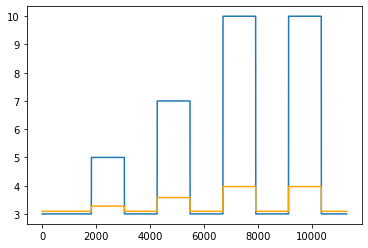

In [14]:
plt.plot(df_input['time'], df_input['input_voltage'])
plt.plot(df_input['time'], df_input['spinning_soll']/1000, 'orange')
plt.show()

## Predict spinning amount based on input

In [15]:
from sklearn import linear_model

In [16]:
reg_spin = linear_model.Ridge()
reg_spin.fit(df_input[['input_voltage']], df_input['spinning_soll'])

Ridge()

In [17]:
df_validation['spin_predict'] = reg_spin.predict(df_validation[['voltage']])

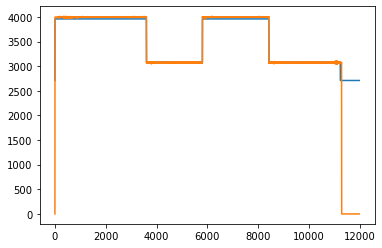

In [18]:
plt.plot(df_validation['time'], df_validation['spin_predict'])
plt.plot(df_validation['time'], df_validation['spinning'])

In [19]:
def measureDifference(data, value_header, approx_header):
    R_SQUARED = True
    RSME = True
    
    data = data[data[approx_header].notnull()]
    values = data[value_header]
    approx = data[approx_header]
    
    if RSME:
        rms = metrics.mean_squared_error(values, approx, squared=False)
        print('The RMSE is %5.3f' %rms)
    if R_SQUARED:
        r2 = metrics.r2_score(values, approx)
        print('The R2-score is %5.3f' %r2)

In [28]:
measureDifference(df_validation, 'spinning', 'spin_predict')

The RMSE is 724.739
The R2-score is 0.498


## Predict voltage amount based on input

In [24]:
reg_volt = linear_model.Ridge()
reg_volt.fit(np.array(df_input['input_voltage']).reshape(-1,1), df_input['el_power'])

Ridge()

In [26]:
df_validation['el_predict'] = reg_volt.predict(df_validation[['voltage']])

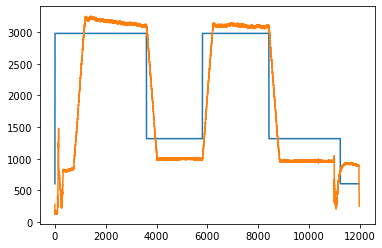

In [27]:
plt.plot(df_validation['time'], df_validation['el_predict'])
plt.plot(df_validation['time'], df_validation['electric'])

In [29]:
measureDifference(df_validation, 'electric', 'el_predict')

The RMSE is 747.571
The R2-score is 0.505


## Predict thermal output amount based on input

In [30]:
reg_thermal = linear_model.Ridge()
reg_thermal.fit(np.array(df_input['input_voltage']).reshape(-1,1), df_input['th_power'])

Ridge()

In [32]:
df_validation['th_predict'] = reg_volt.predict(df_validation[['voltage']])

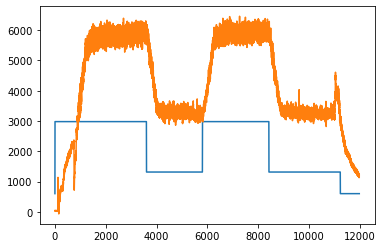

In [33]:
plt.plot(df_validation['time'], df_validation['th_predict'])
plt.plot(df_validation['time'], df_validation['thermal'])

In [34]:
measureDifference(df_validation, 'thermal', 'th_predict')

The RMSE is 2408.636
The R2-score is -1.331
